In [3]:
from foundational_ssm.data_utils.dataset import TorchBrainDataset
from foundational_ssm.constants import DATA_ROOT
import os
dataset = TorchBrainDataset(
    root=os.path.join(DATA_ROOT, "perich_miller_population_2018"),
    recording_id="m_20140221_random_target_reaching",
)

In [4]:
smoothed_spikes = dataset.get_recording_data("m_20140221_random_target_reaching").smoothed_spikes

In [5]:
smoothed_spikes.smoothed_spikes.shape

(96136, 127)

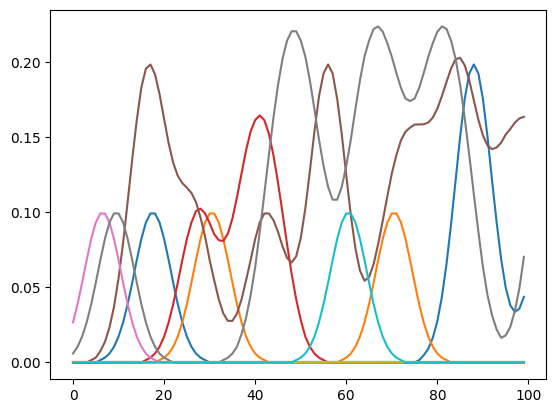

In [9]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(smoothed_spikes.smoothed_spikes[:100,i])

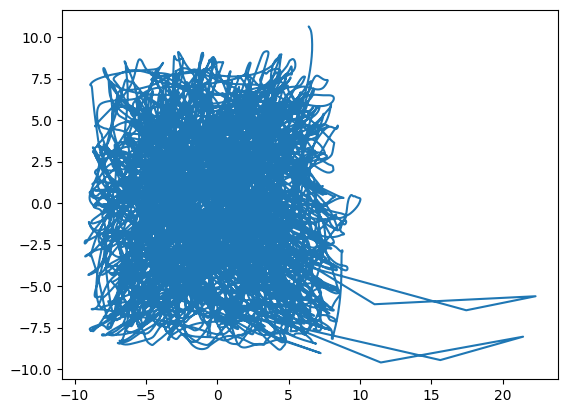

In [10]:
import matplotlib.pyplot as plt
cursor_position = dataset.get_recording_data("m_20140221_random_target_reaching").cursor.pos 
plt.plot(cursor_position[:,0], cursor_position[:,1])
plt.show()

In [1]:
import os
import sys
import warnings
import logging
from collections import defaultdict


# Typing
from typing import List, Dict

# Hydra & config
import hydra
from omegaconf import OmegaConf, DictConfig

# JAX & Equinox
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
from jax.tree_util import tree_map, tree_flatten_with_path
import optax
import wandb

# Foundational SSM core imports
from foundational_ssm.data_utils import get_train_val_loaders, get_dataset_config
from foundational_ssm.models import SSMFoundational
from foundational_ssm.loss import CombinedLoss
from foundational_ssm.utils import log_model_params_and_grads_wandb, save_model_wandb
from foundational_ssm.constants import DATASET_IDX_TO_GROUP_SHORT


def compute_r2_standard(preds, targets):
    """
    Computes the standard coefficient of determination (R²) for each output dimension.
    
    Args:
        preds: Predictions array of shape (num_samples, output_dim)
        targets: Targets array of shape (num_samples, output_dim)
        
    Returns:
        The mean R² across all output dimensions.
    """
    preds_flat = preds.reshape(-1, preds.shape[-1]) 
    targets_flat = targets.reshape(-1, targets.shape[-1])
    ss_res = jnp.sum((targets_flat - preds_flat) ** 2, axis=0) 
    ss_tot = jnp.sum((targets_flat - jnp.mean(targets_flat, axis=0)) ** 2, axis=0)
    zero_variance = ss_tot < 1e-8
    r2_per_dim = 1 - ss_res / (ss_tot + 1e-8) # Add epsilon for stability
    
    return jnp.mean(r2_per_dim)

@eqx.filter_jit
def predict_batch(model, state, inputs, key):
    """Predict on a batch of inputs using JAX's vmap"""
    batch_keys = jr.split(key, inputs.shape[0])
    preds, _ = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0))(inputs, state, batch_keys)
    return preds

@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def mse_loss(model_params, model_static, state, inputs, targets, dataset_group_idx, key):
    model = eqx.combine(model_params, model_static)
    batch_keys = jr.split(key, inputs.shape[0])
    preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0, None), out_axes=(0, None))(inputs, state, batch_keys, dataset_group_idx)
    mse = jnp.mean((preds - targets) ** 2)
    return (mse, state)

@eqx.filter_jit
def make_step(model, state, filter_spec, inputs, targets, dataset_group_idx, loss_fn, opt, opt_state, key):
    model_params, model_static = eqx.partition(model, filter_spec)
    (value, state), grads = loss_fn(model_params, model_static, state, inputs, targets, dataset_group_idx, key)
    updates, opt_state = opt.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return model, state, opt_state, value, grads


cfg = OmegaConf.load("../configs/pretrain.yaml")
train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(
        train_config=get_dataset_config(
            cfg.train_dataset.name,
            subjects=['j']
        ),
        val_config=get_dataset_config(
            cfg.val_dataset.name,
            subjects=['j']
        ),
        batch_size=4
    )

In [3]:
import matplotlib.pyplot as plt
for batch in train_loader:
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    # plt.plot(inputs[0, :, 1])
    # plt.plot(binned_spikes[0, :, 1])
    # plt.show()
    # plt.plot(targets[0, :, 0])
    break

In [5]:
inputs.shape

(4, 100, 353)

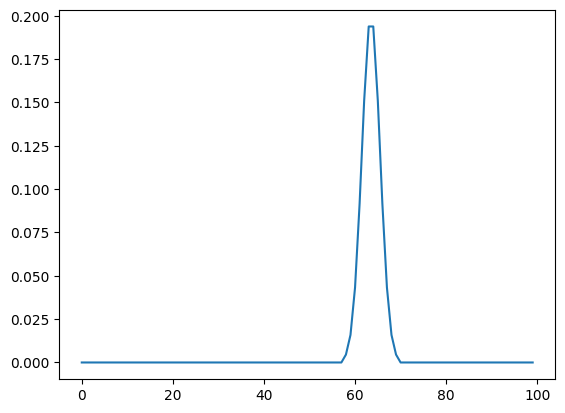

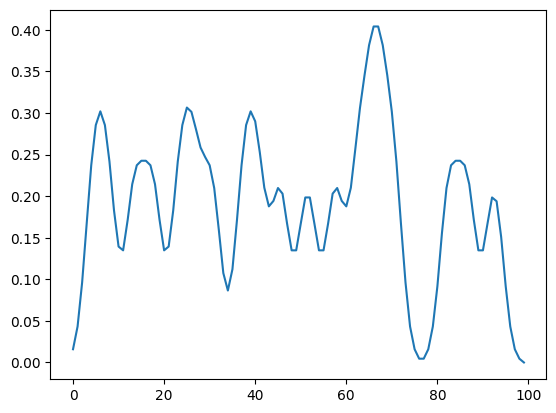

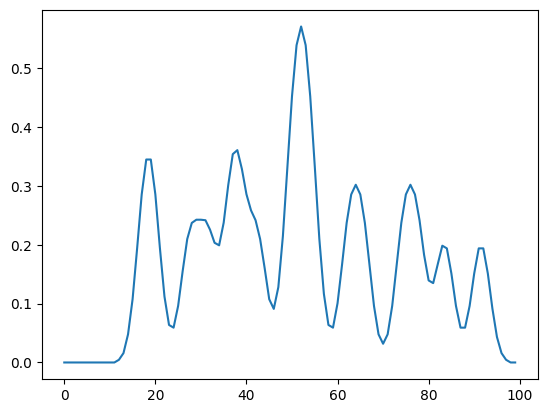

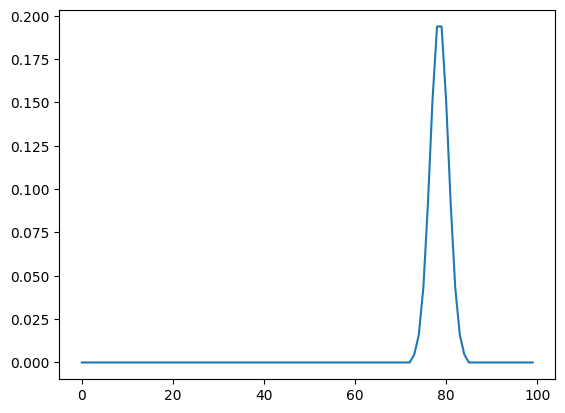

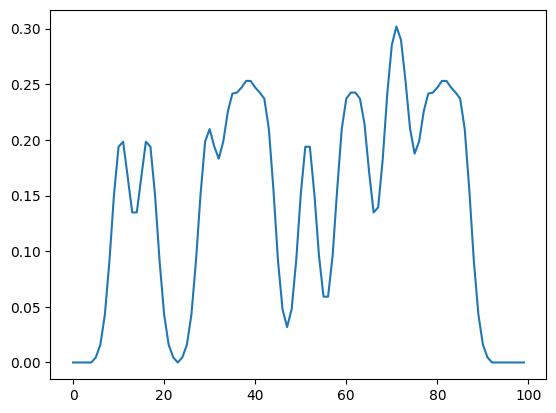

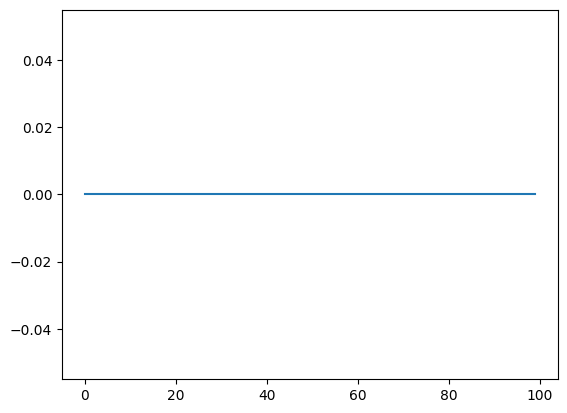

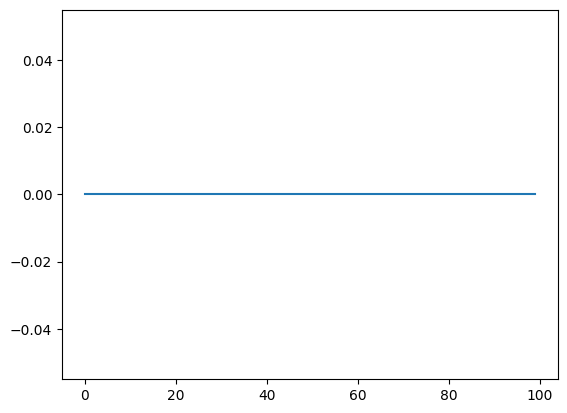

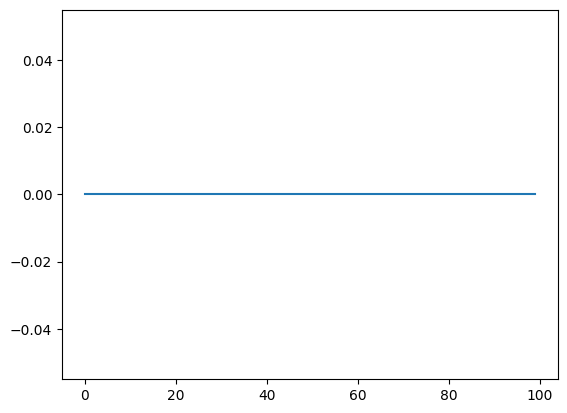

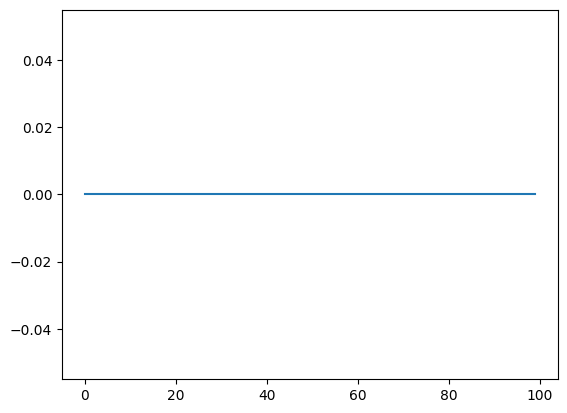

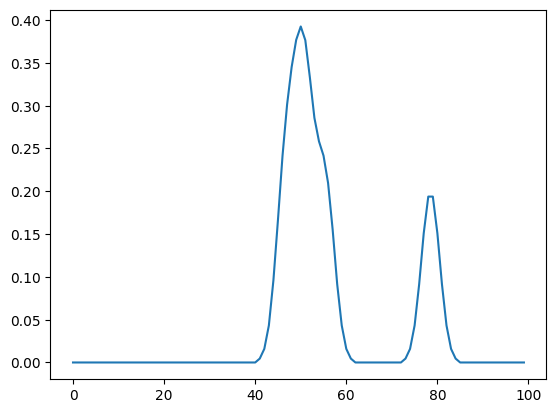

In [4]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(inputs[0, :, i])
    plt.show()

In [2]:
sampling_intervals = train_dataset.get_sampling_intervals()
for key in sampling_intervals.keys():
    start, end = sampling_intervals[key].start, sampling_intervals[key].end
    break
sample = train_dataset.get(key, start[0], end[0])

In [ ]:
@hydra.main(config_path="../configs", config_name="pretrain", version_base="1.3")
def main(cfg: DictConfig):
    print(OmegaConf.to_yaml(cfg))

    # Load dataset
    train_dataset, train_loader, val_dataset, val_loader = get_train_val_loaders(
        train_config=get_dataset_config(
            cfg.train_dataset.name,
            subjects=cfg.train_dataset.subjects
        ),
        val_config=get_dataset_config(
            cfg.val_dataset.name,
            subjects=cfg.val_dataset.subjects
        ),
        batch_size=cfg.train_dataset.batch_size
    )
    
    key = jr.PRNGKey(cfg.rng_seed)
    model_key, train_key, val_key = jr.split(key, 3)

    model = SSMFoundational(
            ssm_io_dim = cfg.model.ssm_io_dim,
            ssm_dim = cfg.model.ssm_dim,
            ssm_init_diag_blocks = cfg.model.ssm_init_diag_blocks,
            ssm_num_layers = cfg.model.ssm_num_layers,
            output_dim = cfg.model.output_dim,
            rng_seed = cfg.model.model_rng_seed,
        )
    state = eqx.nn.State(model)
    
    print(model)
    
    # Filter spec for freezing parts of the model
    filter_spec = tree_map(eqx.is_inexact_array, model)
    
    # Calculate total training steps for scheduler
    total_steps = len(train_loader) * cfg.training.epochs
    
    # Create scheduler based on config
    use_cosine_scheduler = getattr(cfg.optimizer, 'use_cosine_scheduler', True)  # Default to True for backward compatibility
    
    if use_cosine_scheduler:
        # Create cosine annealing scheduler
        lr_scheduler = create_cosine_annealing_scheduler(
            initial_lr=cfg.optimizer.lr,
            total_steps=total_steps,
            min_lr=getattr(cfg.optimizer, 'min_lr', 0.0),  # Default to 0.0 if not specified
            warmup_steps=getattr(cfg.optimizer, 'warmup_steps', 0)  # Default to 0 if not specified
        )
    else:
        # Use constant learning rate
        lr_scheduler = lambda step: cfg.optimizer.lr
    
    # Load JAX optimizer with scheduler
    opt = optax.chain(
        optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
    )
    opt_state = opt.init(eqx.filter(model, filter_spec))
    
    # Load JAX loss function
    loss_fn = mse_loss
    
    run_name = f"{cfg.train_dataset.name}_l{cfg.model.ssm_num_layers}_d{cfg.model.ssm_dim}"
    config_dict = OmegaConf.to_container(cfg, resolve=True)
    wandb.init(project=cfg.wandb_project, name=run_name, config=config_dict)  # type: ignore
    
    best_r2_score = 0
    save_model_wandb(model, run_name, OmegaConf.to_container(cfg.model), wandb.run)
    
    # Track current step for scheduler
    current_step = 0
    
    for epoch in range(cfg.training.epochs):
        epoch_loss = 0
        for batch in train_loader:
            inputs = batch["neural_input"]
            targets = batch["behavior_input"]
            dataset_group_idx = batch["dataset_group_idx"][0]
            
            key, subkey = jr.split(train_key)
            
            model, state, opt_state, loss_value, grads = make_step(
                model,
                state,
                filter_spec,
                inputs, 
                targets, 
                dataset_group_idx,
                loss_fn,
                opt,
                opt_state,  
                subkey
            )
            
            # Get current learning rate from scheduler
            current_lr = lr_scheduler(current_step)
            
            wandb.log({
                "loss": loss_value,
                "learning_rate": current_lr,
                "step": current_step
            })
            epoch_loss += loss_value
            current_step += 1
            
        if epoch % cfg.training.log_every == 0:
            wandb.log({"epoch_train_loss": epoch_loss})
            
            total_r2_score = 0
            group_preds = defaultdict(list)
            group_targets = defaultdict(list)
            for batch in val_loader:
                inputs = batch["neural_input"]
                targets = batch["behavior_input"]
                dataset_group_idx = batch["dataset_group_idx"][0]
                dataset_group_key = DATASET_IDX_TO_GROUP_SHORT[dataset_group_idx]
                
                key, subkey = jr.split(val_key)
                batch_keys = jr.split(subkey, inputs.shape[0])
                preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0, None), out_axes=(0, None))(inputs, state, batch_keys, dataset_group_idx)
                group_preds[dataset_group_key].append(preds)
                group_targets[dataset_group_key].append(targets)
                
            for group_key, preds in group_preds.items():
                preds = jnp.concatenate(preds, axis=0)
                targets = jnp.concatenate(group_targets[group_key], axis=0)
                r2_score = compute_r2_standard(preds, targets)
                wandb.log({f"val_r2_{group_key}": r2_score, "epoch_train_loss": epoch_loss})
                total_r2_score += r2_score
            avg_r2_score = total_r2_score / len(group_preds)
            
            if avg_r2_score > best_r2_score:
                best_r2_score = avg_r2_score
                save_model_wandb(model, run_name, OmegaConf.to_container(cfg.model), wandb.run)
            
            print(f"Epoch {epoch}/{cfg.training.epochs}, Loss: {epoch_loss:.4f}")
    
    wandb.finish()
            
if __name__ == "__main__":
    main()
    
